In [1]:
!pip install sastrawi

In [2]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [3]:
import time
import datetime
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import string, re
import itertools
import plotly.offline as py
import plotly.graph_objs as go
from collections import Counter

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from textblob import Word

# from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, roc_curve, auc,accuracy_score,f1_score, classification_report
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, recall_score, precision_score


from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation, GRU, Flatten,BatchNormalization
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras.layers import Convolution1D,Conv1D, MaxPooling1D
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
from keras.models import model_from_json
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, Dense, GRU, Dropout, Bidirectional, SpatialDropout1D
from tensorflow.keras.utils import to_categorical

py.init_notebook_mode(connected=True)

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

tf.random.set_seed(1234)

ModuleNotFoundError: No module named 'wordcloud'

In [ ]:
import os
import numpy as np 
import pandas as pd 

In [ ]:
df=pd.read_csv('drive/MyDrive/data-label-2.csv')

In [ ]:
df.head()

,Label,Tweet
0,Non_Bully,Jadilah orang yang bertanggung jawab atas sega...
1,Non_Bully,"Menurut Anda, apakah #SidangAhok Dugaan Penist..."
2,Non_Bully,Semua kejujuran akan mendapatkan pahala dari s...
3,Non_Bully,Jadilah orang yang bertanggung jawab atas sega...
4,Non_Bully,#MataNajwaDebatJakarta terima kasih telah memb...


In [ ]:
df.shape

(520, 2)

In [ ]:
df.Label.value_counts()

Bully        260
Non_Bully    260
Name: Label, dtype: int64

Text Preprocessing: Stemming, Stop-Words removal and Lemmatization

In [ ]:
# function to clean the word in html tags
def cleanhtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr,' ',sentence)
    return cleantext

# function to clean the word of any punctuation
def cleanpunc(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#]', r'', sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]', r' ',cleaned)
    return cleaned

def words(text): return re.findall(r'\w+', text.lower())

In [ ]:
factory = StemmerFactory()
ps = factory.create_stemmer()
factory = StopWordRemoverFactory()
stop= factory.get_stop_words()
stopwordlist=words(open('drive/MyDrive/stopwords.txt').read())
stopword=stop+stopwordlist

Code for implementing step by step the checks mentioned in the preprocessing

In [ ]:
def preprocess_data(data):
    i=0
    str1= ' '
    final_string = []
    for sent in data['Tweet'].values:
        filtered_sentence = []
        sent = cleanhtml(sent)
        # remove html tags
        for w in sent.split():
            for cleaned_words in cleanpunc(w).split():
                if ((cleaned_words.isalpha()) & (len(cleaned_words)>2)):
                    if (cleaned_words.lower() not in stopword):
                        s = (ps.stem(cleaned_words.lower()))
                        filtered_sentence.append(s)
                    else:
                        continue
                else:
                    continue
        str1 = " ".join(filtered_sentence) # final string of cleaned words

        final_string.append(str1)
        i+=1
    return final_string

In [ ]:
df['Cleaned_text'] = preprocess_data(df) 

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [ ]:
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(20, 10))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off")

In [ ]:
word_cloud = WordCloud().generate(str(df['Cleaned_text']))

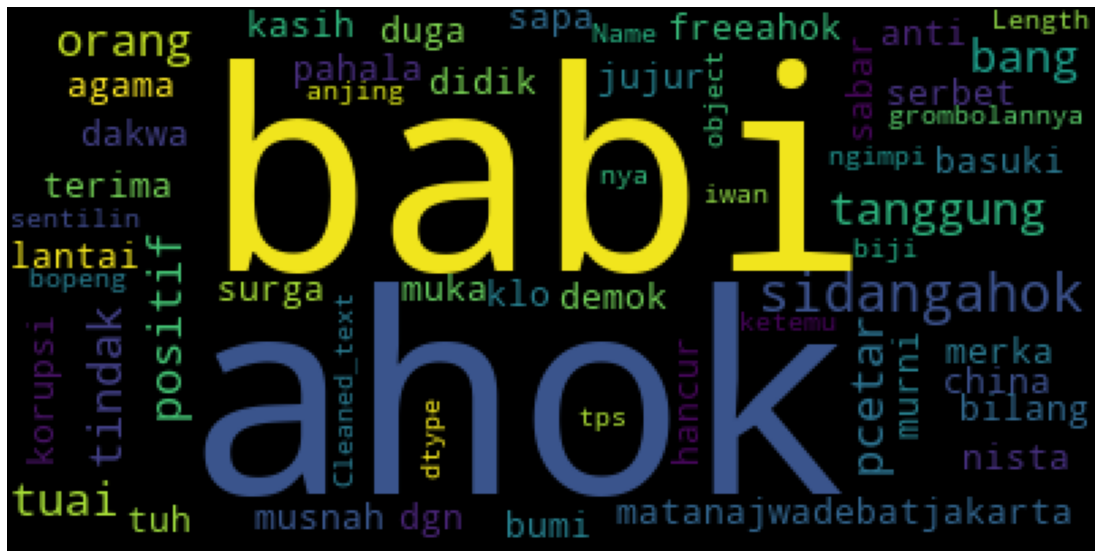

In [ ]:
plot_cloud(word_cloud)

NEGATIVE WORDS

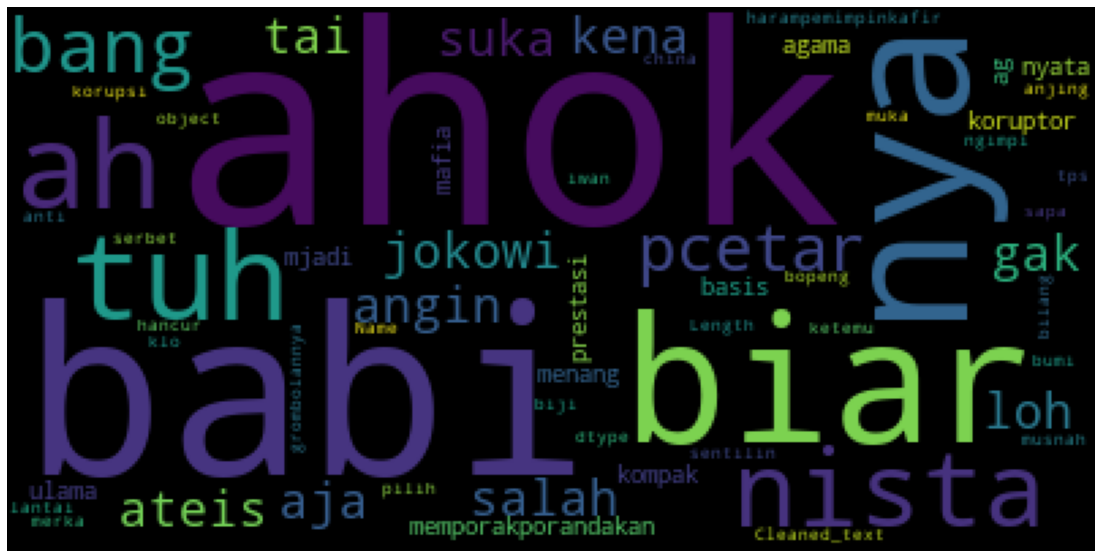

In [ ]:
word_cloud = WordCloud().generate(str(df[df['Label'] == 'Bully']['Cleaned_text']))
plot_cloud(word_cloud)

POSITIVE WORDS

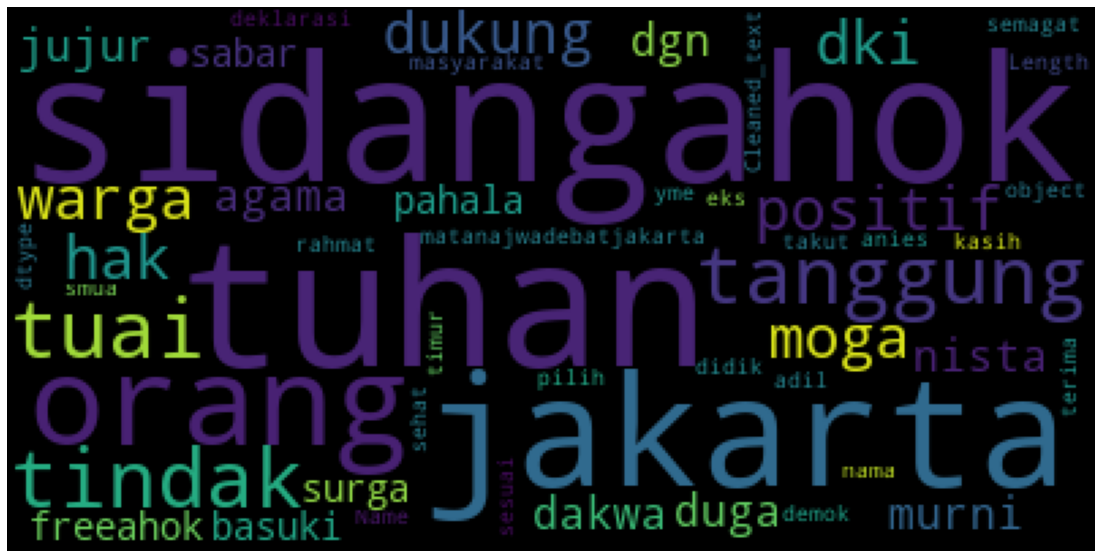

In [ ]:
word_cloud = WordCloud().generate(str(df[df['Label'] == 'Non_Bully']['Cleaned_text']))
plot_cloud(word_cloud)

In [ ]:
df['Label']

0      Non_Bully
1      Non_Bully
2      Non_Bully
3      Non_Bully
4      Non_Bully
         ...    
515        Bully
516        Bully
517        Bully
518        Bully
519        Bully
Name: Label, Length: 520, dtype: object

In [ ]:
def label(x):
    if x=='Non_Bully':
        return 0
    else:
        return 1

In [ ]:
df['Label']=df['Label'].apply(label)

Split data into training and testing set

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['Cleaned_text'].values, df['Label'].values, test_size=0.3,random_state=42)

In [ ]:
# initialize Tokenizer to encode strings into integers
train_df=df.copy()
tokenizer = Tokenizer()

# calculate number of rows in our dataset
num_rows = train_df.shape[0]

# create vocabulary from all words in our dataset for encoding
tokenizer.fit_on_texts(train_df['Cleaned_text'].values)

# max length of 1 row (number of words)
row_max_length = max([len(x.split()) for x in train_df['Cleaned_text'].values])

# count number of unique words
vocabulary_size = len(tokenizer.word_index) + 1

# convert words into integers
X_train_tokens = tokenizer.texts_to_sequences(X_train)
X_test_tokens = tokenizer.texts_to_sequences(X_test)

# ensure every row has same size - pad missing with zeros
X_train_pad = pad_sequences(X_train_tokens, maxlen=row_max_length, padding='post')
X_test_pad = pad_sequences(X_test_tokens, maxlen=row_max_length, padding='post')


Labels preprocessing

In [ ]:
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

target_length = y_train_cat.shape[1]
print('Original vector size: {}'.format(y_train.shape))
print('Converted vector size: {}'.format(y_train_cat.shape))

Original vector size: (364,)
Converted vector size: (364, 2)


In [ ]:
def plot_performance(history=None, figure_directory=None, ylim_pad=[0, 0]):
    xlabel = 'Epoch'
    legends = ['Training', 'Validation']

    plt.figure(figsize=(20, 5))

    y1 = history.history['accuracy']
    y2 = history.history['val_accuracy']

    min_y = min(min(y1), min(y2))-ylim_pad[0]
    max_y = max(max(y1), max(y2))+ylim_pad[0]


    plt.subplot(121)

    plt.plot(y1)
    plt.plot(y2)

    plt.title('Model Accuracy\n', fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Accuracy', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()

    y1 = history.history['loss']
    y2 = history.history['val_loss']

    min_y = min(min(y1), min(y2))-ylim_pad[1]
    max_y = max(max(y1), max(y2))+ylim_pad[1]


    plt.subplot(122)

    plt.plot(y1)
    plt.plot(y2)

   
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Loss', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()
    if figure_directory:
        plt.savefig(figure_directory+"/history")

    plt.show()

LSTM MODEL

In [ ]:
np.random.seed(1337)

print('Build model...')

vocabulary_size = len(tokenizer.word_index) + 1
row_max_length = max([len(x.split()) for x in df['Cleaned_text'].values])

EMBEDDING_DIM = 256

# LSTM
lstm_output_size = 70

model = Sequential()
model.add(Embedding(vocabulary_size, EMBEDDING_DIM, input_length=row_max_length))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(lstm_output_size))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(target_length, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train_pad, y_train_cat, epochs=7, validation_data=(X_test_pad, y_test_cat), batch_size=2,shuffle=False)

Build model...
Epoch 1/7
182/182 [==============================] - 5s 19ms/step - loss: 0.6719 - accuracy: 0.5797 - val_loss: 0.4011 - val_accuracy: 0.8333
Epoch 2/7
182/182 [==============================] - 3s 17ms/step - loss: 0.1726 - accuracy: 0.9451 - val_loss: 0.4794 - val_accuracy: 0.8077
Epoch 3/7
182/182 [==============================] - 3s 17ms/step - loss: 0.0356 - accuracy: 0.9918 - val_loss: 0.4012 - val_accuracy: 0.8782
Epoch 4/7
182/182 [==============================] - 3s 17ms/step - loss: 0.0096 - accuracy: 0.9973 - val_loss: 0.3171 - val_accuracy: 0.9103
Epoch 5/7
182/182 [==============================] - 3s 17ms/step - loss: 1.8837e-04 - accuracy: 1.0000 - val_loss: 0.3417 - val_accuracy: 0.9103
Epoch 6/7
182/182 [==============================] - 3s 17ms/step - loss: 1.0869e-04 - accuracy: 1.0000 - val_loss: 0.3654 - val_accuracy: 0.9103
Epoch 7/7
182/182 [==============================] - 3s 17ms/step - loss: 6.9399e-05 - accuracy: 1.0000 - val_loss: 0.3817 - 

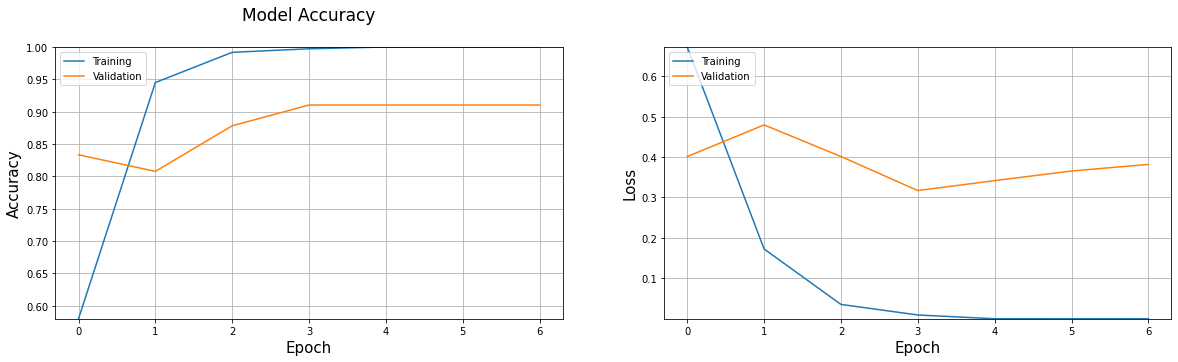

In [ ]:
plot_performance(history=history)

In [ ]:
y_pred_ = model.predict(X_test_pad)
y_pred = [np.argmax(x) for x in y_pred_]

In [ ]:
print("Accuracy of the model : ", accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

Accuracy of the model :  0.9102564102564102
              precision    recall  f1-score   support

           0       0.91      0.91      0.91        80
           1       0.91      0.91      0.91        76

    accuracy                           0.91       156
   macro avg       0.91      0.91      0.91       156
weighted avg       0.91      0.91      0.91       156



In [ ]:
cm_plot_labels = ['no_bully','bully']

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

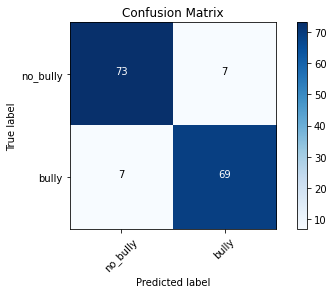

In [ ]:
cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

Naive Bayes

In [ ]:
CountVec = CountVectorizer(ngram_range=(1,1), 
                           stop_words=stopword)
#transform
Count_data = CountVec.fit_transform(df['Cleaned_text'])
 
#create dataframe
X=pd.DataFrame(Count_data.toarray(),columns=CountVec.get_feature_names())
print(X)

     aamiin  abang  abdi  abis  abu  aceh  ...  yme  yoi  yos  you  yuk  zikir
0         0      0     0     0    0     0  ...    0    0    0    0    0      0
1         0      0     0     0    0     0  ...    0    0    0    0    0      0
2         0      0     0     0    0     0  ...    0    0    0    0    0      0
3         0      0     0     0    0     0  ...    0    0    0    0    0      0
4         0      0     0     0    0     0  ...    0    0    0    0    0      0
..      ...    ...   ...   ...  ...   ...  ...  ...  ...  ...  ...  ...    ...
515       0      0     0     0    0     0  ...    0    0    0    0    0      0
516       0      0     0     0    0     0  ...    0    0    0    0    0      0
517       0      0     0     0    0     0  ...    0    0    0    0    0      0
518       0      0     0     0    0     0  ...    0    0    0    0    0      0
519       0      0     0     0    0     0  ...    0    0    0    0    0      0

[520 rows x 1588 columns]


In [ ]:
sdf=pd.concat([X,df['Label']],axis=1)

In [ ]:
Y=df.Label.values

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.3,random_state=42)

In [ ]:
nb = MultinomialNB()
nb.fit(X_train, Y_train)
predictions_test = nb.predict(X_test)
print('Test Accuracy:', accuracy_score(Y_test, predictions_test))

Test Accuracy: 0.9294871794871795


In [ ]:
print("Accuracy of the model : ", accuracy_score(Y_test,predictions_test))
print(classification_report(Y_test,predictions_test))

Accuracy of the model :  0.9294871794871795
              precision    recall  f1-score   support

           0       0.93      0.94      0.93        80
           1       0.93      0.92      0.93        76

    accuracy                           0.93       156
   macro avg       0.93      0.93      0.93       156
weighted avg       0.93      0.93      0.93       156



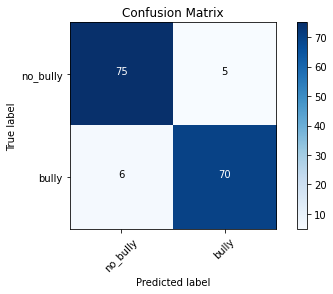

In [ ]:
cm2 = confusion_matrix(Y_test,predictions_test)
plot_confusion_matrix(cm=cm2, classes=cm_plot_labels, title='Confusion Matrix')

Perbandingan Model

In [ ]:
desc_model = ['LSTM Model',
            'Naive Bayes']

## loop for all model
datatr = []
datasc = []
Recall =[]
Precision =[]
auc_test =[]

for i in desc_model:
    if i=='LSTM Model':
        y_pred_train_ = model.predict(X_train_pad)
        y_pred_train = [np.argmax(x) for x in y_pred_train_]
        y_pred_ = model.predict(X_test_pad)
        y_pred = [np.argmax(x) for x in y_pred_]
        datatr.append(accuracy_score(y_train,y_pred_train))
        datasc.append(accuracy_score(y_test,y_pred))
        Recall.append(recall_score(y_test,y_pred))
        Precision.append(precision_score(y_test,y_pred))
        auc_test.append(roc_auc_score(y_test,y_pred))
        
    else:
        y_pred_train = nb.predict(X_train)
        y_pred = nb.predict(X_test)
        datatr.append(accuracy_score(Y_train,y_pred_train))
        datasc.append(accuracy_score(y_test,y_pred))
        Recall.append(recall_score(Y_test,y_pred))
        Precision.append(precision_score(Y_test,y_pred))
        auc_test.append(roc_auc_score(Y_test,y_pred))

## compare model each other
data1 = pd.DataFrame()
data1['model'] = desc_model
data1['Accuracy training'] = datatr
data1['Accuracy test'] = datasc
data1['Precision'] = Precision
data1['Recall']= Recall
data1['AUC_test']=auc_test
data1['f1_score']= 2*(data1['Precision']*data1['Recall'])/(data1['Precision']+data1['Recall'])
data1['gap'] = abs(data1['Accuracy training'] - data1['Accuracy test'])
data1.sort_values(by='Accuracy test',ascending=False)

,model,Accuracy training,Accuracy test,Precision,Recall,AUC_test,f1_score,gap
1,Naive Bayes,0.989011,0.929487,0.933333,0.921053,0.929276,0.927152,0.059524
0,LSTM Model,1.000000,0.910256,0.907895,0.907895,0.910197,0.907895,0.089744
